In [1]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [2]:
cd "/content/drive/My Drive/major"

/content/drive/My Drive/major


In [3]:
!pip install numpy pandas scipy scikit-learn nose matplotlib pillow h5py scikit-image soundfile librosa tensorflow keras==2.1.0

In [4]:
import tensorflow as tf
tf.test.gpu_device_name()

'/device:GPU:0'

In [5]:
!ln -sf /opt/bin/nvidia-smi /usr/bin/nvidia-smi
!pip install gputil
!pip install psutil
!pip install humanize
import psutil
import humanize
import os
import GPUtil as GPU
GPUs = GPU.getGPUs()
# XXX: only one GPU on Colab and isn’t guaranteed
gpu = GPUs[0]
def printm():
 process = psutil.Process(os.getpid())
 print("Gen RAM Free: " + humanize.naturalsize( psutil.virtual_memory().available ), " | Proc size: " + humanize.naturalsize( process.memory_info().rss))
 print("GPU RAM Free: {0:.0f}MB | Used: {1:.0f}MB | Util {2:3.0f}% | Total {3:.0f}MB".format(gpu.memoryFree, gpu.memoryUsed, gpu.memoryUtil*100, gpu.memoryTotal))
printm()

Gen RAM Free: 8.9 GB  | Proc size: 892.4 MB
GPU RAM Free: 12062MB | Used: 3017MB | Util  20% | Total 15079MB


In [6]:
import numpy as np
data=np.load("all_signal_data.npy")
label=np.load("all_signal_label.npy")


from keras.models import Sequential
from keras.optimizers import Adam
from keras.layers import Dense,Dropout,Activation,Flatten,Conv2D,MaxPooling2D,InputLayer,Reshape
from keras.layers.normalization import BatchNormalization
from keras.wrappers.scikit_learn import KerasClassifier

from sklearn.preprocessing import LabelEncoder,MinMaxScaler,StandardScaler
from sklearn.model_selection import cross_val_score,KFold
from sklearn.metrics import accuracy_score
le=LabelEncoder()
label=le.fit_transform(label)
from keras.utils import to_categorical
label=to_categorical(label)

Using TensorFlow backend.


In [0]:
sc=StandardScaler()
X=[]
for i in range(len(data)):
  data[i]=sc.fit_transform(data[i])
  #X.append(data[i].ravel())
from keras.preprocessing.image import load_img,array_to_img,img_to_array
#array_to_img(data[0].reshape(data[0].shape[0],data[0].shape[1],1))

In [0]:
def custom_model():
    model=Sequential()
    model.add(Conv2D(64,kernel_size=5,activation='relu',input_shape=(129,295,1)))
    model.add(MaxPooling2D(pool_size=(3,3),strides=(1,1)))
    model.add(BatchNormalization())
    model.add(Dropout(rate=0.5))
    model.add(Conv2D(64,kernel_size=3,activation='relu'))
    model.add(MaxPooling2D(pool_size=(3,3),strides=(1,1)))
    model.add(BatchNormalization())
    model.add(Dropout(rate=0.5))
    model.add(Flatten())
    model.add(Dense(82,activation='softmax'))
    model.compile(optimizer='adam',loss='categorical_crossentropy',metrics=['accuracy'],)
    return model

In [0]:
X = data#np.array(X)/255
y=label

from sklearn.model_selection import train_test_split
train_x,test_x,train_y,test_y =  train_test_split(X,y,test_size = .2)

import tensorflow as tf
img_size = 48
img_size_flat = tf.placeholder(dtype=tf.float32,shape=(129,295))
img_shape = [129,295,1]
img_shape_full = [129,295,1]
num_classes = 82

def Model():
    model = Sequential()
    inp_shape=(129,295)
    model.add(InputLayer(input_shape=inp_shape))
    #print("shape outputted by the Input layer: ",model.output_shape)
    model.add(Reshape(target_shape = img_shape_full))
    #model.add(BatchNormalization())
    #print("shape outputted by the reshape layer: ",model.output_shape)
    model.add(Conv2D(filters = 16,kernel_size = 5,input_shape = img_shape_full,activation = 'relu',strides = (1,1),padding = 'same',name = 'layer_conv1'))
    model.add(BatchNormalization())
    #print("shape outputted by the first convolutional layer: ",model.output_shape)
    model.add(MaxPooling2D(pool_size = (2,2),strides = (1,1)))
    #model.add(Dropout(0.5))
    #print("shape outputted by the MaxPooling Layer layer: ",model.output_shape)
    model.add(Conv2D(filters = 32,kernel_size = 5,activation = 'relu',strides = (2,2),padding = 'same',name = 'layer_conv2'))
    #print("shape outputted by the second Convolutional layer: ",model.output_shape)
    #model.add(MaxPooling2D(pool_size = (3,3),strides = (2,2)))
    model.add(BatchNormalization())
    #model.add(Dropout(0.5))
    #print("shape outputted by the second Maxpooling layer: ",model.output_shape)
    model.add(Conv2D(filters = 64,kernel_size = 7,activation = 'relu'))
    model.add(BatchNormalization())
    #print("shape outputted by the convolutional layer: ",model.output_shape)
    #model.add(MaxPooling2D(pool_size = (3,3), strides = (2,2)))
    model.add(Conv2D(filters = 12,kernel_size = 3,strides = (2,2),activation = 'relu'))
    model.add(BatchNormalization())
    
    model.add(Conv2D(filters = 19,kernel_size = 5,activation = 'relu'))
    model.add(BatchNormalization())

    #model.add(Dropout(rate = 0.5))
    #print("shape outputted by the Dropout layer: ",model.output_shape)
    model.add(Flatten())
    #print("shape outputted by the after flatten layer: ",model.output_shape)
    #model.add(Dense(1024,activation = 'sigmoid'))
    #model.add(Dropout(0.5))
    model.add(Dense(512,activation = 'sigmoid'))
    model.add(Dropout(0.1))
    #print("shape outputted by the after Dense layer: ",model.output_shape)
    model.add(Dense(num_classes,activation = 'softmax'))
    model.add(Dropout(0.1))
    optimizer = Adam(.001)
    model.compile(optimizer = optimizer,loss = 'categorical_crossentropy', metrics = ['accuracy','top_k_categorical_accuracy'])
    history = model.fit(x= train_x,y=train_y,epochs = 50,batch_size = 16,validation_split=0.1)
    result = model.evaluate(x = test_x,y = test_y)
    for name,value in zip(model.metrics_names,result):
        print('{0}: {1}'.format(name,value))
    return model,history

In [15]:
m,history = Model()
#m.fit(x= train_x,y=train_y,epochs = 10,batch_size = 16,validation_split=0.1)
result = m.evaluate(x = test_x,y = test_y)
for name,value in zip(m.metrics_names,result):
    print('{0}: {1}'.format(name,value))

Train on 1537 samples, validate on 171 samples
Epoch 1/50
1537/1537 [==============================] - 10s 6ms/step - loss: 4.5085 - acc: 0.2622 - top_k_categorical_accuracy: 0.4776 - val_loss: 3.0834 - val_acc: 0.2164 - val_top_k_categorical_accuracy: 0.5263
Epoch 2/50
1537/1537 [==============================] - 8s 5ms/step - loss: 2.9080 - acc: 0.5882 - top_k_categorical_accuracy: 0.7820 - val_loss: 2.9258 - val_acc: 0.2982 - val_top_k_categorical_accuracy: 0.5439
Epoch 3/50
1537/1537 [==============================] - 8s 5ms/step - loss: 2.2961 - acc: 0.7677 - top_k_categorical_accuracy: 0.8679 - val_loss: 2.1440 - val_acc: 0.4620 - val_top_k_categorical_accuracy: 0.7485
Epoch 4/50
1537/1537 [==============================] - 8s 5ms/step - loss: 1.9354 - acc: 0.8543 - top_k_categorical_accuracy: 0.8926 - val_loss: 1.4727 - val_acc: 0.6140 - val_top_k_categorical_accuracy: 0.8596
Epoch 5/50
1537/1537 [==============================] - 8s 5ms/step - loss: 1.9478 - acc: 0.8692 - top_k

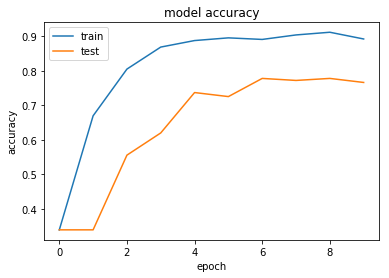

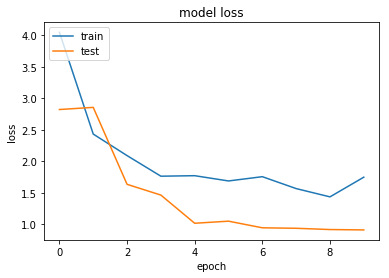

In [11]:
import matplotlib.pyplot as plt
plt.plot(history.history['acc'])
plt.plot(history.history['val_acc'])
plt.title('model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()
# summarize history for loss
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()


In [12]:
m.summary()
m.save('implementation1.h5')

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         (None, 129, 295)          0         
_________________________________________________________________
reshape_1 (Reshape)          (None, 129, 295, 1)       0         
_________________________________________________________________
layer_conv1 (Conv2D)         (None, 129, 295, 16)      416       
_________________________________________________________________
batch_normalization_1 (Batch (None, 129, 295, 16)      64        
_________________________________________________________________
max_pooling2d_1 (MaxPooling2 (None, 128, 294, 16)      0         
_________________________________________________________________
layer_conv2 (Conv2D)         (None, 64, 147, 32)       12832     
_________________________________________________________________
batch_normalization_2 (Batch (None, 64, 147, 32)       128       
__________

In [13]:
import keras
print(keras.__version__)

2.1.0
